In [2]:
import cudf
import matplotlib.pyplot as plt
import numpy as np

In [3]:
%%time 
transactions = cudf.read_csv('storage/transactions_train.csv')
articles = cudf.read_csv('storage/articles.csv')
customers = cudf.read_csv('storage/customers.csv')

CPU times: user 1.13 s, sys: 1.65 s, total: 2.79 s
Wall time: 4.06 s


In [4]:
transactions['t_dat'] = cudf.to_datetime(transactions['t_dat'])
transactions['days'] = transactions['t_dat'] - transactions['t_dat'].min()
transactions['days'] = transactions['days'].dt.days
transactions['customer_id'] = transactions['customer_id'].str[-16:].str.hex_to_int().astype('int64')

In [4]:
test_transactions = transactions[transactions.t_dat>cudf.to_datetime('2020-09-15')].to_pandas()

****Max duration between purchase****

In [30]:
tmp = transactions.groupby('article_id')['days'].unique().to_pandas()
max_duration_between_purchase = tmp.apply(lambda x: np.diff(x).max() if len(x) > 1 else 0).to_frame().reset_index()
max_duration_between_purchase = max_duration_between_purchase.rename(columns={'days':'max_duration_between_purchase'})
min_duration_between_purchase = tmp.apply(lambda x: np.diff(x).min() if len(x) > 1 else 0).to_frame().reset_index()
min_duration_between_purchase = min_duration_between_purchase.rename(columns={'days':'min_duration_between_purchase'})

In [31]:
test_transactions = test_transactions.merge(max_duration_between_purchase,on='article_id',how='left')

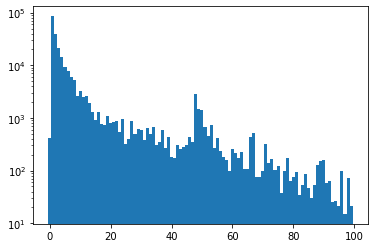

In [39]:
_ = plt.hist(test_transactions['max_duration_between_purchase'],bins=100,range=(-0.5,99.5))
plt.yscale('log')

****Article overlap between week****

In [103]:
def calculate_y(year,i,transactions):
    month = '0'+str(i) if i <= 9 else str(i)
    test_transactions = transactions[(transactions.t_dat>cudf.to_datetime(year+'-'+month+'-07'))&(transactions.t_dat<=cudf.to_datetime(year+'-'+month+'-15'))].to_pandas()
    tmp2 = test_transactions['article_id'].unique().tolist()
    test_transactions = transactions[(transactions.t_dat>cudf.to_datetime(year+'-'+month+'-15'))&(transactions.t_dat<=cudf.to_datetime(year+'-'+month+'-22'))].to_pandas()
    tmp1 = test_transactions['article_id'].unique().tolist()
    l3 = len(set(tmp1).intersection(tmp2))
    return l3/len(tmp1)
                    
xs_2020 = list(range(1,10))
ys_2020 = [calculate_y('2020',x,transactions) for x in xs_2020]
xs_2019 = list(range(1,13))
ys_2019 = [calculate_y('2019',x,transactions) for x in xs_2019]

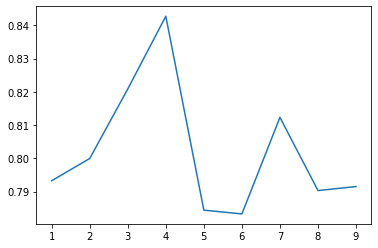

In [104]:
_ = plt.plot(xs_2020,ys_2020)

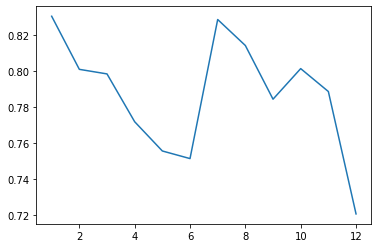

In [105]:
_ = plt.plot(xs_2019,ys_2019)

****EDA between two consecutive weeks****

In [5]:
year = '2020'
month = '09'
first_week_transactions = transactions[(transactions.t_dat>cudf.to_datetime(year+'-'+month+'-07'))&(transactions.t_dat<=cudf.to_datetime(year+'-'+month+'-15'))]
second_week_transactions = transactions[(transactions.t_dat>cudf.to_datetime(year+'-'+month+'-15'))&(transactions.t_dat<=cudf.to_datetime(year+'-'+month+'-22'))]

In [6]:
first_group = first_week_transactions[['customer_id','article_id','days','price']].groupby(['customer_id','article_id'])['price'].count().to_frame().reset_index()
second_group = second_week_transactions[['customer_id','article_id','days','price']].groupby(['customer_id','article_id'])['price'].count().to_frame().reset_index()

In [24]:
first_group.index.isin(second_group.index).sum()

array(48423)

In [52]:
tmp = second_group.merge(first_group,on=['customer_id','article_id'],how='left')

In [57]:
tmp.dropna()['customer_id'].unique()

0      -9221250204668709066
1      -9218986600601340908
2      -9218627569625385985
3      -9214429801920134650
4      -9199279625727034653
               ...         
2595    9179272753060610929
2596    9182560242589374461
2597    9189079026526008779
2598    9207961283470270227
2599    9209634455387509795
Name: customer_id, Length: 2600, dtype: int64

In [59]:
second_week_transactions['customer_id'].unique()

0       -9223100958908512198
1       -9223002534477110135
2       -9222810895170663723
3       -9221924794303263774
4       -9221811157628158522
                ...         
68979    9221607025486275188
68980    9221813808370389952
68981    9222310594107555341
68982    9223099843213569889
68983    9223141695752178477
Name: customer_id, Length: 68984, dtype: int64

In [9]:
first_week_transactions['article_id'].value_counts()[:20]

909370001    1306
865799006     844
918522001     819
924243001     718
448509014     716
751471001     693
918292001     616
762846027     606
809238001     567
706016001     555
863646001     552
715624001     540
673677002     528
751471043     522
915526001     519
809238005     503
850917001     499
915529003     494
896169005     486
863583001     469
Name: article_id, dtype: int32

In [10]:
second_week_transactions['article_id'].value_counts()[:20]

924243001    852
924243002    635
918522001    609
923758001    592
866731001    552
909370001    537
751471001    526
915529003    495
915529005    491
448509014    490
762846027    474
714790020    468
918292001    441
865799006    439
850917001    429
929275001    416
896169005    413
919273002    409
889550002    404
935541001    401
Name: article_id, dtype: int32